In [1]:
from pulp import *
import numpy as np
import pandas as pd
import re
from collections import defaultdict
import datetime
from dateutil.relativedelta import *
import xlwings as xw
from collections import Counter
import ctypes
import os
import math
import Entity
import CrossEntityLink as lk
import AllocOptimizer as ao
import WrangleData as wd
import matplotlib.pyplot as plt

> Three core elements of corporate cash planning:
1. position/cash flow forecast
2. market rate forecast
3. adherence to internal and external limits.

## Case I

In [23]:
#import data
path = 'fund_actual_data.xls'
data,_, balance_daily,balance,\
        balance_a_daily ,balance_a,\
            balance_b_daily,balance_b,\
                balance_c_daily,balance_c,\
                    in_bal_days, rate_path, week_index, bank_limit = wd.wrangle_data(path)

In [24]:

prob = LpProblem("The_Funding_Allocation_Problem",LpMaximize)
hq = Entity.Entity(name = 'HQ')
hq.construct_bal_cf(balance)
#hq.construct_fx_vars(fx, in_bal_days, balance_daily, balance, week_index,by_day = False)
hq.construct_product_vars(data.loc[data['Company'] == 'HQ'], in_bal_days, balance_daily,balance, rate_path, week_index,by_day = False)
hq.var_init()
#objective function
prob += hq.obj
entity_lst = [hq]
intercomp_lst = []
bank_limit_lst = [[[hq],bank_limit]]
opt = ao.Optimizer(prob ,entity_lst, intercomp_lst, bank_limit_lst)
opt.solver()
# opt.output(to_excel = True)
df_bal_all, df_flow_all, contribution,df_fx_bal_all,df_fx_flow_all, df_intercomp_all = opt.output()


Status: Optimal


>Saving amount is prepared for payment and the rest is placed in 1 month time deposit.
If the tenor can match the payment date, the model will place all cash in higher yielding TD, as is the case on the TD placed on 6/26 and paid on 7/24.

In [25]:
df_bal_all['indx'] = df_bal_all['Bank'] + "_"+df_bal_all['Curr'] +  "_"+df_bal_all['Product']
pd.pivot_table(df_bal_all.loc[df_bal_all['Curr'] == 'USD'],values = ['Value'], columns = ['Date'], index = ['indx'])

Value                                              \
Date               2020-05-01 2020-05-08 2020-05-15 2020-05-22 2020-05-29   
indx                                                                        
BankA_USD_1M             50.0       50.0       50.0       50.0       50.0   
BankA_USD_SpecialS       50.0       50.0       50.0        0.0        0.0   
BankB_USD_1M              0.0        0.0        0.0        0.0        0.0   
BankB_USD_Saving          0.0        0.0        0.0        0.0        0.0   

                                                                           \
Date               2020-06-05 2020-06-12 2020-06-19 2020-06-26 2020-07-03   
indx                                                                        
BankA_USD_1M             60.0       60.0       60.0       60.0      130.0   
BankA_USD_SpecialS       50.0       50.0       50.0        0.0        0.0   
BankB_USD_1M              0.0        0.0        0.0        0.0        0.0   
BankB_USD_Saving          0.0        0.0        0.0        0.0        0.0   

                                                                
Date               2020-07-10 2020-07-17 2020-07-24 2020-07-31  
indx                                                            
BankA_USD_1M            130.0      130.0       80.0      180.0  
BankA_USD_SpecialS        0.0        0.0        0.0        0.0  
BankB_USD_1M              0.0        0.0        0.0        0.0  
BankB_USD_Saving          0.0        0.0        0.0        0.0

>We can observe the cash flows. The time deposits are roll-overed in 4 weeks.

In [26]:
df_flow_all['indx'] = df_flow_all['Bank'] + "_"+df_flow_all['Curr'] +  "_"+df_flow_all['Product'] +'_'+df_flow_all['INorOut']
df = df_flow_all.loc[df_flow_all['indx'].str.contains('BankA_USD_1M')]
pd.pivot_table(df,values = ['Value'], columns = ['Date'], index = ['indx'])


Value                                              \
Date             2020-05-01 2020-05-08 2020-05-15 2020-05-22 2020-05-29   
indx                                                                      
BankA_USD_1M_in        50.0        0.0        0.0        0.0       50.0   
BankA_USD_1M_out        0.0        0.0        0.0        0.0      -50.0   

                                                                         \
Date             2020-06-05 2020-06-12 2020-06-19 2020-06-26 2020-07-03   
indx                                                                      
BankA_USD_1M_in        10.0        0.0        0.0       50.0       80.0   
BankA_USD_1M_out        0.0        0.0        0.0      -50.0      -10.0   

                                                              
Date             2020-07-10 2020-07-17 2020-07-24 2020-07-31  
indx                                                          
BankA_USD_1M_in         0.0        0.0        0.0      180.0  
BankA_USD_1M_out        0.0        0.0      -50.0      -80.0

>contribution - if the principle amounts are in million,1M TD would generate 5.875/100 million in interest income in the three month period.

In [12]:
contribution.groupby(['Bank','Curr','product'])['contribution'].sum().reset_index().sort_values(['contribution'], ascending = False)

,Bank,Curr,product,contribution
2,BankA,USD,1M,5.875000
3,BankA,USD,SpecialS,0.166667
0,BankA,EUR,Saving,0.000000
1,BankA,JPY,Saving,0.000000
4,BankB,EUR,Saving,0.000000
5,BankB,JPY,Saving,0.000000
6,BankB,USD,1M,0.000000
7,BankB,USD,Saving,0.000000


#### Product Specific Constraints

> Sometimes banks will offer certain rates with caveate, such as the maximum amount per trade, the minimum balance or average balance over a period of time. Now suppose bank A limits the highest yielding TD to 20 per week and demands a average saving balance to be greater than 50 as it wishes to maintain a stable funding source for perhaps regulatory reason. The new constraints are shown as below.

In [37]:
data.loc[0,'Daily_max'] = 20
data.loc[1,'average'] = '>50'
data.loc[data['Curr'] == 'USD']

,Company,Bank,Curr,product,rate,Date,Daily_max,Daily_min,average,Tenor
0,HQ,BankA,USD,1M,0.25,2020-05-01,20.0,NaN,NaN,30
1,HQ,BankA,USD,SpecialS,0.20,2020-05-01,NaN,NaN,>50,0
6,HQ,BankB,USD,Saving,0.00,2020-05-01,NaN,NaN,NaN,0
7,HQ,BankB,USD,1M,0.23,2020-05-01,NaN,NaN,NaN,30
8,CompA,BankA,USD,1M,0.60,2020-05-01,NaN,NaN,NaN,30
9,CompA,BankB,USD,SpecialS,0.35,2020-05-01,200.0,NaN,NaN,0
10,CompB,BankA,USD,1M,0.60,2020-05-01,NaN,NaN,NaN,30
11,CompB,BankB,USD,SpecialS,0.35,2020-05-01,200.0,NaN,NaN,0
12,CompC,BankA,USD,1M,0.60,2020-05-01,NaN,NaN,NaN,30
13,CompC,BankB,USD,SpecialS,0.35,2020-05-01,200.0,NaN,NaN,0


In [33]:
prob = LpProblem("The_Funding_Allocation_Problem",LpMaximize)
hq = Entity.Entity(name = 'HQ')
hq.construct_bal_cf(balance)
#hq.construct_fx_vars(fx, in_bal_days, balance_daily, balance, week_index,by_day = False)
hq.construct_product_vars(data.loc[data['Company'] == 'HQ'], in_bal_days, balance_daily,balance, rate_path, week_index,by_day = False)
hq.var_init()
#objective function
prob += hq.obj
entity_lst = [hq]
intercomp_lst = []
bank_limit_lst = [[[hq],bank_limit]]
opt = ao.Optimizer(prob ,entity_lst, intercomp_lst, bank_limit_lst)
opt.solver()
# opt.output(to_excel = True)
df_bal_all, df_flow_all, contribution,df_fx_bal_all,df_fx_flow_all, df_intercomp_all = opt.output()


Status: Optimal


> We can see that the model does adhere to the capacity constraints by doing no more than 20 in bank A TD per week.

In [38]:
df_flow_all['indx'] = df_flow_all['Bank'] + "_"+df_flow_all['Curr'] +  "_"+df_flow_all['Product'] +'_'+df_flow_all['INorOut']
df = df_flow_all.loc[df_flow_all['indx'].str.contains('_USD_1M')]
pd.pivot_table(df,values = ['Value'], columns = ['Date'], index = ['indx'])

Value                                              \
Date             2020-05-01 2020-05-08 2020-05-15 2020-05-22 2020-05-29   
indx                                                                      
BankA_USD_1M_in        15.0        0.0       10.0       20.0       20.0   
BankA_USD_1M_out        0.0        0.0        0.0        0.0      -15.0   
BankB_USD_1M_in         0.0        0.0        0.0        0.0        0.0   
BankB_USD_1M_out        0.0        0.0        0.0        0.0        0.0   

                                                                         \
Date             2020-06-05 2020-06-12 2020-06-19 2020-06-26 2020-07-03   
indx                                                                      
BankA_USD_1M_in         0.0       10.0        0.0       20.0       20.0   
BankA_USD_1M_out        0.0      -10.0      -20.0      -20.0        0.0   
BankB_USD_1M_in         0.0        0.0        0.0       30.0       50.0   
BankB_USD_1M_out        0.0        0.0        0.0        0.0        0.0   

                                                              
Date             2020-07-10 2020-07-17 2020-07-24 2020-07-31  
indx                                                          
BankA_USD_1M_in        10.0        0.0        0.0       20.0  
BankA_USD_1M_out      -10.0        0.0      -20.0      -20.0  
BankB_USD_1M_in         0.0        0.0        0.0      150.0  
BankB_USD_1M_out        0.0        0.0      -30.0      -50.0

> As there are payments on 20th each month, inevitablly we have to put enough cash in saving account. In the first two month the model allocates more cash in bank A saving to get higher interest rate. Later in July, as the payment amount is sufficiently covered by TD due, the funds are placed in TD with bank A & bank B.

In [34]:
df_bal_all['indx'] = df_bal_all['Bank'] + "_"+df_bal_all['Curr'] +  "_"+df_bal_all['Product']
pd.pivot_table(df_bal_all.loc[df_bal_all['Curr'] == 'USD'],values = ['Value'], columns = ['Date'], index = ['indx'])

Value                                              \
Date               2020-05-01 2020-05-08 2020-05-15 2020-05-22 2020-05-29   
indx                                                                        
BankA_USD_1M             15.0       15.0       25.0       45.0       50.0   
BankA_USD_SpecialS       85.0       85.0       75.0        5.0        0.0   
BankB_USD_1M              0.0        0.0        0.0        0.0        0.0   
BankB_USD_Saving          0.0        0.0        0.0        0.0        0.0   

                                                                           \
Date               2020-06-05 2020-06-12 2020-06-19 2020-06-26 2020-07-03   
indx                                                                        
BankA_USD_1M             50.0       50.0       30.0       30.0       50.0   
BankA_USD_SpecialS       60.0       60.0       80.0        0.0        0.0   
BankB_USD_1M              0.0        0.0        0.0       30.0       80.0   
BankB_USD_Saving          0.0        0.0        0.0        0.0        0.0   

                                                                
Date               2020-07-10 2020-07-17 2020-07-24 2020-07-31  
indx                                                            
BankA_USD_1M             50.0       50.0       30.0       30.0  
BankA_USD_SpecialS        0.0        0.0        0.0        0.0  
BankB_USD_1M             80.0       80.0       50.0      150.0  
BankB_USD_Saving          0.0        0.0        0.0        0.0

## Case 2

### Case 2-1 Introducing Loan

> Bank Loan is another common funding tool for corporates. The model will recognize loan related products when the bank name ends with "Loan". Here we introduce a 7 day short term loan as example, with the same settings as our first example. 

In [48]:
path = 'fund_actual_data_2.xls'
data, _ , balance_daily,balance,\
        balance_a_daily ,balance_a,\
            balance_b_daily,balance_b,\
                balance_c_daily,balance_c,\
                    in_bal_days, rate_path, week_index, bank_limit = wd.wrangle_data(path)
data.loc[(data['Company'].str.contains('HQ')) & (data['Curr'] == 'USD')]

,Company,Bank,Curr,product,rate,Date,Daily_max,Daily_min,average,Tenor
0,HQ,BankA,USD,1M,0.25,2020-05-01,NaN,NaN,NaN,30
1,HQ,BankA,USD,SpecialS,0.20,2020-05-01,NaN,NaN,NaN,0
6,HQ,BankB,USD,Saving,0.00,2020-05-01,NaN,NaN,NaN,0
7,HQ,BankB,USD,1M,0.23,2020-05-01,NaN,NaN,NaN,30
8,HQ,BankCLoan,USD,1W,-0.30,2020-05-01,NaN,NaN,NaN,7


In [49]:
#import data

               
prob = LpProblem("The_Funding_Allocation_Problem",LpMaximize)
hq = Entity.Entity(name = 'HQ')
hq.construct_bal_cf(balance)
#hq.construct_fx_vars(fx, in_bal_days, balance_daily, balance, week_index,by_day = False)
hq.construct_product_vars(data.loc[data['Company'] == 'HQ'], in_bal_days, balance_daily,balance, rate_path, week_index,by_day = False)
hq.var_init()
#objective function
prob += hq.obj
entity_lst = [hq]
intercomp_lst = []
bank_limit_lst = [[[hq],bank_limit]]
opt = ao.Optimizer(prob ,entity_lst, intercomp_lst, bank_limit_lst)
opt.solver()
opt.output(to_excel = True)
df_bal_all, df_flow_all, contribution,df_fx_bal_all,df_fx_flow_all, df_intercomp_all = opt.output()



Status: Optimal


> short term loan for payment if the interest expense is lower than interest income. No more saving. 
The last period may seem weird, suggestion: at least expand the period by the longest tenor of all products.

In [50]:
df_bal_all['indx'] = df_bal_all['Bank'] + "_"+df_bal_all['Curr'] +  "_"+df_bal_all['Product']
pd.pivot_table(df_bal_all.loc[df_bal_all['Curr'] == 'USD'],values = ['Value'], columns = ['Date'], index = ['indx'])

Value                                              \
Date               2020-05-01 2020-05-08 2020-05-15 2020-05-22 2020-05-29   
indx                                                                        
BankA_USD_1M            100.0      100.0      100.0      100.0       50.0   
BankA_USD_SpecialS        0.0        0.0        0.0        0.0        0.0   
BankB_USD_1M              0.0        0.0        0.0        0.0        0.0   
BankB_USD_Saving          0.0        0.0        0.0        0.0        0.0   
BankCLoan_USD_1W          0.0        0.0        0.0       50.0        0.0   

                                                                           \
Date               2020-06-05 2020-06-12 2020-06-19 2020-06-26 2020-07-03   
indx                                                                        
BankA_USD_1M            110.0      110.0      110.0       60.0      130.0   
BankA_USD_SpecialS        0.0        0.0        0.0        0.0        0.0   
BankB_USD_1M              0.0        0.0        0.0        0.0        0.0   
BankB_USD_Saving          0.0        0.0        0.0        0.0        0.0   
BankCLoan_USD_1W          0.0        0.0        0.0        0.0        0.0   

                                                                
Date               2020-07-10 2020-07-17 2020-07-24 2020-07-31  
indx                                                            
BankA_USD_1M            130.0      130.0      130.0      180.0  
BankA_USD_SpecialS        0.0        0.0        0.0        0.0  
BankB_USD_1M              0.0        0.0        0.0        0.0  
BankB_USD_Saving          0.0        0.0        0.0        0.0  
BankCLoan_USD_1W          0.0        0.0       50.0        0.0

### Case 2-2 Interest rate forecast

> The model can incorporate interest rate forecast in the optimization. Generally speaking, interest rates can be influenced by several factors, including both macro and ideosyncratic reasons such as central bank monetary policies, banks' quarterly balance sheet management, market sentiments, to name just a few. It is possible to forecast interest rates with predictive models like time series analysis if the company holds sufficient historical data. Here I only demonstrate a simple use case, but it is worth noting that we can apply different interest rate paths to different products, currencies and even banking institutions as deemed suitable. 

> Suppose the central bank is raising base rate by 0.25% on 6/1, thus all USD denominated products will equally increase by the same magnitude on that date.

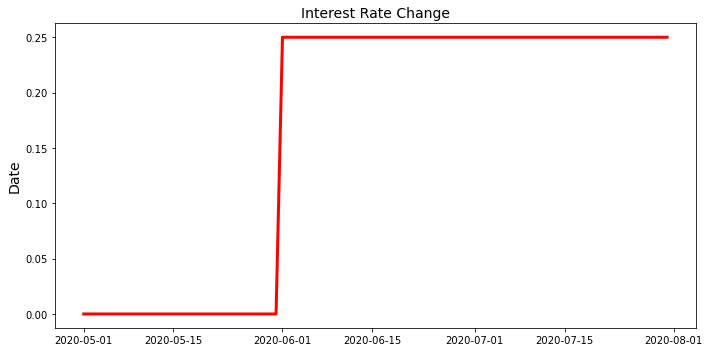

In [51]:
indx = rate_path['USD'].loc[rate_path['USD']['Date'] == datetime.datetime(2020,6,1)].index[0]
rate_path['USD'].iloc[31:,1] = np.repeat(0.25, len(rate_path['USD'].index)-indx)

fig, ax0 = plt.subplots(figsize=(10, 5))
ax0.plot(rate_path['USD']['Date'], rate_path['USD']['Rate'], color='red',linewidth=3.0)

ax0.set_title('Interest Rate Change', fontsize = 14)
ax0.set_ylabel('Rate Change',fontsize = 14)
ax0.set_ylabel('Date',fontsize = 14)
fig.tight_layout()

In [52]:
prob = LpProblem("The_Funding_Allocation_Problem",LpMaximize)
hq = Entity.Entity(name = 'HQ')
hq.construct_bal_cf(balance)
#hq.construct_fx_vars(fx, in_bal_days, balance_daily, balance, week_index,by_day = False)
hq.construct_product_vars(data.loc[data['Company'] == 'HQ'], in_bal_days, balance_daily,balance, rate_path, week_index,by_day = False)
hq.var_init()
#objective function
prob += hq.obj
entity_lst = [hq]
intercomp_lst = []
bank_limit_lst = [[[hq],bank_limit]]
opt = ao.Optimizer(prob ,entity_lst, intercomp_lst, bank_limit_lst)
opt.solver()
opt.output(to_excel = True)
df_bal_all, df_flow_all, contribution,df_fx_bal_all,df_fx_flow_all, df_intercomp_all = opt.output()



Status: Optimal


In [53]:
df_bal_all['indx'] = df_bal_all['Bank'] + "_"+df_bal_all['Curr'] +  "_"+df_bal_all['Product']
pd.pivot_table(df_bal_all.loc[df_bal_all['Curr'] == 'USD'],values = ['Value'], columns = ['Date'], index = ['indx'])

Value                                              \
Date               2020-05-01 2020-05-08 2020-05-15 2020-05-22 2020-05-29   
indx                                                                        
BankA_USD_1M            100.0      100.0      100.0      100.0        0.0   
BankA_USD_SpecialS        0.0        0.0        0.0        0.0       50.0   
BankB_USD_1M              0.0        0.0        0.0        0.0        0.0   
BankB_USD_Saving          0.0        0.0        0.0        0.0        0.0   
BankCLoan_USD_1W          0.0        0.0        0.0       50.0        0.0   

                                                                           \
Date               2020-06-05 2020-06-12 2020-06-19 2020-06-26 2020-07-03   
indx                                                                        
BankA_USD_1M            110.0      110.0      110.0      110.0      130.0   
BankA_USD_SpecialS        0.0        0.0        0.0        0.0        0.0   
BankB_USD_1M              0.0        0.0        0.0        0.0        0.0   
BankB_USD_Saving          0.0        0.0        0.0        0.0        0.0   
BankCLoan_USD_1W          0.0        0.0        0.0       50.0        0.0   

                                                                
Date               2020-07-10 2020-07-17 2020-07-24 2020-07-31  
indx                                                            
BankA_USD_1M            130.0      130.0      130.0      180.0  
BankA_USD_SpecialS        0.0        0.0        0.0        0.0  
BankB_USD_1M              0.0        0.0        0.0        0.0  
BankB_USD_Saving          0.0        0.0        0.0        0.0  
BankCLoan_USD_1W          0.0        0.0       50.0        0.0

### Bank Limits & Facility

> As best risk management principle dictates: don't put all your eggs in one basket, corporate cash planning has to take into account various internal and external constraints on the maximum business exposure to a certain counterpart or a certain product. This model requires per bank limit as input. User should provide remaining limits for the optimizing period for every banks, otherwise the model will reture unbounded result. The remaining limits are calculated as total limit - outstanding transaction amount for each day, which signifies how much more business we can engage with the bank. The limit should never be negative.  

> Now suppose bank A has lower credit rating than bank B, therefore we set internal limits for the two banks at 100 & 500, respectively. In addition, bank C agrees to lend to us by no more than 30. The bank_limit data is shown below. 

In [56]:
bank_limit['BankCLoan'] = {i:30 for i,j in bank_limit['BankCLoan'].items()}
bank_limit['BankA'] = {i:100 for i,j in bank_limit['BankA'].items()}
bank_limit['BankB'] = {i:500 for i,j in bank_limit['BankB'].items()}
pd.DataFrame(bank_limit).head()

,BankCLoan,BankA,BankB
20200501,30,100,500
20200502,30,100,500
20200503,30,100,500
20200504,30,100,500
20200505,30,100,500


In [57]:
prob = LpProblem("The_Funding_Allocation_Problem",LpMaximize)
hq = Entity.Entity(name = 'HQ')
hq.construct_bal_cf(balance)
#hq.construct_fx_vars(fx, in_bal_days, balance_daily, balance, week_index,by_day = False)
hq.construct_product_vars(data.loc[data['Company'] == 'HQ'], in_bal_days, balance_daily,balance, rate_path, week_index,by_day = False)
hq.var_init()
#objective function
prob += hq.obj
entity_lst = [hq]
intercomp_lst = []
bank_limit_lst = [[[hq],bank_limit]]
opt = ao.Optimizer(prob ,entity_lst, intercomp_lst, bank_limit_lst)
opt.solver()
opt.output(to_excel = True)
df_bal_all, df_flow_all, contribution,df_fx_bal_all,df_fx_flow_all, df_intercomp_all = opt.output()

Status: Optimal


> Output as shown below, is  very similar to the previous example, but the model reserve cash in the beginning as a result of loan facility constraint. Moreover, bank B is utilized as bank A reaches its limit. 

In [58]:
df_bal_all['indx'] = df_bal_all['Bank'] + "_"+df_bal_all['Curr'] +  "_"+df_bal_all['Product']
pd.pivot_table(df_bal_all.loc[df_bal_all['Curr'] == 'USD'],values = ['Value'], columns = ['Date'], index = ['indx'])

Value                                              \
Date               2020-05-01 2020-05-08 2020-05-15 2020-05-22 2020-05-29   
indx                                                                        
BankA_USD_1M             70.0       78.0       78.0       78.0        8.0   
BankA_USD_SpecialS       29.0       21.0       21.0        0.0       42.0   
BankB_USD_1M              1.0        1.0        1.0        1.0        0.0   
BankB_USD_Saving          0.0        0.0        0.0        0.0        0.0   
BankCLoan_USD_1W          0.0        0.0        0.0       29.0        0.0   

                                                                           \
Date               2020-06-05 2020-06-12 2020-06-19 2020-06-26 2020-07-03   
indx                                                                        
BankA_USD_1M             57.0       57.0       57.0       57.0       99.0   
BankA_USD_SpecialS       42.0       42.0       42.0        0.0        0.0   
BankB_USD_1M             11.0       11.0       11.0       32.0       31.0   
BankB_USD_Saving          0.0        0.0        0.0        0.0        0.0   
BankCLoan_USD_1W          0.0        0.0        0.0       29.0        0.0   

                                                                
Date               2020-07-10 2020-07-17 2020-07-24 2020-07-31  
indx                                                            
BankA_USD_1M             99.0       99.0       99.0       99.0  
BankA_USD_SpecialS        0.0        0.0        0.0        0.0  
BankB_USD_1M             31.0       31.0       10.0       81.0  
BankB_USD_Saving          0.0        0.0        0.0        0.0  
BankCLoan_USD_1W          0.0        0.0       29.0        0.0

## Case 3

### Case 3-1 Introducing Spot Transactions

In [74]:
#import data
path = 'fund_actual_data_2.xls'
data, fx, balance_daily,balance,\
        balance_a_daily ,balance_a,\
            balance_b_daily,balance_b,\
                balance_c_daily,balance_c,\
                    in_bal_days, rate_path, week_index, bank_limit = wd.wrangle_data(path)
               


In [62]:
fx_spot = fx.loc[fx['type'] == 'spot']
fx_spot

,type,from,to,Tenor,GL,Date
0,spot,USD,JPY,0,0.0,2020-05-01
1,spot,USD,EUR,0,0.0,2020-05-01
2,spot,EUR,USD,0,0.0,2020-05-01
3,spot,JPY,USD,0,0.0,2020-05-01


In [63]:
prob = LpProblem("The_Funding_Allocation_Problem",LpMaximize)
hq = Entity.Entity(name = 'HQ')
hq.construct_bal_cf(balance)
hq.construct_fx_vars(fx_spot, in_bal_days, balance_daily, balance, week_index,by_day = False)
hq.construct_product_vars(data.loc[data['Company'] == 'HQ'], in_bal_days, balance_daily,balance, rate_path, week_index,by_day = False)
hq.var_init()
#objective function
prob += hq.obj
entity_lst = [hq]
intercomp_lst = []
bank_limit_lst = [[[hq],bank_limit]]
opt = ao.Optimizer(prob ,entity_lst, intercomp_lst, bank_limit_lst)
opt.solver()
opt.output(to_excel = True)
df_bal_all, df_flow_all, contribution,df_fx_bal_all,df_fx_flow_all, df_intercomp_all = opt.output()



Status: Optimal


> With spot transaction, we can transfer between different currecies. Since EUR and JPY saving yields are negligible, it is best to trade the two currencies with USD via spot transactions and deposit the proceeds in USD deposit. The payment will be fulfilled by borrowing loan and buying EUR/JPY amounts with spot transactions.

In [64]:
df_bal_all['indx'] = df_bal_all['Bank'] + "_"+df_bal_all['Curr'] +  "_"+df_bal_all['Product']
pd.pivot_table(df_bal_all.loc[df_bal_all['Curr'] == 'USD'],values = ['Value'], columns = ['Date'], index = ['indx'])

Value                                              \
Date               2020-05-01 2020-05-08 2020-05-15 2020-05-22 2020-05-29   
indx                                                                        
BankA_USD_1M            300.0      300.0      300.0      300.0      210.0   
BankA_USD_SpecialS        0.0        0.0        0.0        0.0        0.0   
BankB_USD_1M              0.0        0.0        0.0        0.0        0.0   
BankB_USD_Saving          0.0        0.0        0.0        0.0        0.0   
BankCLoan_USD_1W          0.0        0.0        0.0       90.0        0.0   

                                                                           \
Date               2020-06-05 2020-06-12 2020-06-19 2020-06-26 2020-07-03   
indx                                                                        
BankA_USD_1M            270.0      270.0      270.0      160.0      230.0   
BankA_USD_SpecialS        0.0        0.0        0.0        0.0        0.0   
BankB_USD_1M              0.0        0.0        0.0        0.0        0.0   
BankB_USD_Saving          0.0        0.0        0.0        0.0        0.0   
BankCLoan_USD_1W          0.0        0.0        0.0        0.0        0.0   

                                                                
Date               2020-07-10 2020-07-17 2020-07-24 2020-07-31  
indx                                                            
BankA_USD_1M            230.0      230.0      130.0      180.0  
BankA_USD_SpecialS        0.0        0.0        0.0        0.0  
BankB_USD_1M              0.0        0.0        0.0        0.0  
BankB_USD_Saving          0.0        0.0        0.0        0.0  
BankCLoan_USD_1W          0.0        0.0       50.0        0.0

In [69]:
df_fx_flow_all['indx'] = df_fx_flow_all['Curr_from'] + "_"+ df_fx_flow_all['Curr_to'] +  "_"+df_fx_flow_all['product'] + "_"+df_fx_flow_all['INorOut']
pd.pivot_table(df_fx_flow_all,values = ['Value'], columns = ['Date'], index = ['indx'])

Value                                              \
Date            2020-05-01 2020-05-08 2020-05-15 2020-05-22 2020-05-29   
indx                                                                     
EUR_USD_spot_in      100.0        0.0        0.0        0.0        0.0   
JPY_USD_spot_in      100.0        0.0        0.0        0.0        0.0   
USD_EUR_spot_in        0.0        0.0        0.0       20.0        0.0   
USD_JPY_spot_in        0.0        0.0        0.0       20.0        0.0   

                                                                        \
Date            2020-06-05 2020-06-12 2020-06-19 2020-06-26 2020-07-03   
indx                                                                     
EUR_USD_spot_in        0.0        0.0        0.0        0.0        0.0   
JPY_USD_spot_in        0.0        0.0        0.0        0.0        0.0   
USD_EUR_spot_in        0.0        0.0        0.0       30.0        0.0   
USD_JPY_spot_in        0.0        0.0        0.0       30.0        0.0   

                                                             
Date            2020-07-10 2020-07-17 2020-07-24 2020-07-31  
indx                                                         
EUR_USD_spot_in        0.0        0.0        0.0        0.0  
JPY_USD_spot_in        0.0        0.0        0.0        0.0  
USD_EUR_spot_in        0.0        0.0       50.0        0.0  
USD_JPY_spot_in        0.0        0.0       50.0        0.0

### Case 3-2 Introducing Swap Transactions

In [68]:
fx

,type,from,to,Tenor,GL,Date
0,spot,USD,JPY,0,0.0,2020-05-01
1,spot,USD,EUR,0,0.0,2020-05-01
2,spot,EUR,USD,0,0.0,2020-05-01
3,spot,JPY,USD,0,0.0,2020-05-01
4,swap,EUR,USD,7,-0.1,2020-05-01
5,swap,JPY,USD,7,-0.1,2020-05-01
6,swap,USD,EUR,7,0.1,2020-05-01
7,swap,USD,JPY,7,0.1,2020-05-01


In [28]:
prob = LpProblem("The_Funding_Allocation_Problem",LpMaximize)
hq = Entity.Entity(name = 'HQ')
hq.construct_bal_cf(balance)
hq.construct_fx_vars(fx, in_bal_days, balance_daily, balance, week_index,by_day = False)
hq.construct_product_vars(data.loc[data['Company'] == 'HQ'], in_bal_days, balance_daily,balance, rate_path, week_index,by_day = False)
hq.var_init()
#objective function
prob += hq.obj
entity_lst = [hq]
intercomp_lst = []
bank_limit_lst = [[[hq],bank_limit]]
opt = ao.Optimizer(prob ,entity_lst, intercomp_lst, bank_limit_lst)
opt.solver()
opt.output(to_excel = True)
df_bal_all, df_flow_all, contribution,df_fx_bal_all,df_fx_flow_all, df_intercomp_all = opt.output()



Status: Optimal


In [29]:
df_bal_all['indx'] = df_bal_all['Bank'] + "_"+df_bal_all['Curr'] +  "_"+df_bal_all['Product']
pd.pivot_table(df_bal_all.loc[df_bal_all['Curr'] == 'USD'],values = ['Value'], columns = ['Date'], index = ['indx'])

Value                                              \
Date               2020-05-01 2020-05-08 2020-05-15 2020-05-22 2020-05-29   
indx                                                                        
BankA_USD_1M            300.0      300.0      300.0      300.0      210.0   
BankA_USD_SpecialS        0.0        0.0        0.0        0.0        0.0   
BankB_USD_1M              0.0        0.0        0.0        0.0        0.0   
BankB_USD_Saving          0.0        0.0        0.0        0.0        0.0   
BankCLoan_USD_1W          0.0        0.0        0.0       90.0        0.0   

                                                                           \
Date               2020-06-05 2020-06-12 2020-06-19 2020-06-26 2020-07-03   
indx                                                                        
BankA_USD_1M            270.0      270.0      270.0      160.0      230.0   
BankA_USD_SpecialS        0.0        0.0        0.0        0.0        0.0   
BankB_USD_1M              0.0        0.0        0.0        0.0        0.0   
BankB_USD_Saving          0.0        0.0        0.0        0.0        0.0   
BankCLoan_USD_1W          0.0        0.0        0.0        0.0        0.0   

                                                                
Date               2020-07-10 2020-07-17 2020-07-24 2020-07-31  
indx                                                            
BankA_USD_1M            230.0      230.0      130.0      180.0  
BankA_USD_SpecialS        0.0        0.0        0.0        0.0  
BankB_USD_1M              0.0        0.0        0.0        0.0  
BankB_USD_Saving          0.0        0.0        0.0        0.0  
BankCLoan_USD_1W          0.0        0.0       50.0        0.0

In [34]:
df_fx_bal_all['indx'] = df_fx_bal_all['Curr_from'] + "_"+ df_fx_bal_all['Curr_to'] +  "_"+df_fx_bal_all['product']
pd.pivot_table(df_fx_bal_all,values = ['Value'], columns = ['Date'], index = ['indx'])

Value                                              \
Date         2020-05-01 2020-05-08 2020-05-15 2020-05-22 2020-05-29   
indx                                                                  
EUR_USD_spot   999900.0   999900.0   999900.0   999900.0   999900.0   
EUR_USD_swap        0.0        0.0        0.0        0.0        0.0   
JPY_USD_spot      100.0      100.0      100.0      100.0      100.0   
JPY_USD_swap        0.0        0.0        0.0        0.0        0.0   
USD_EUR_spot        0.0        0.0        0.0        0.0        0.0   
USD_EUR_swap   999800.0   999800.0   999800.0   999820.0   999820.0   
USD_JPY_spot        0.0        0.0        0.0        0.0        0.0   
USD_JPY_swap        0.0        0.0        0.0       20.0       20.0   

                                                                     \
Date         2020-06-05 2020-06-12 2020-06-19 2020-06-26 2020-07-03   
indx                                                                  
EUR_USD_spot   999900.0   999900.0   999900.0   999900.0   999900.0   
EUR_USD_swap        0.0        0.0        0.0        0.0        0.0   
JPY_USD_spot      100.0      100.0      100.0      100.0      100.0   
JPY_USD_swap        0.0        0.0        0.0        0.0        0.0   
USD_EUR_spot        0.0        0.0        0.0        0.0        0.0   
USD_EUR_swap   999820.0   999820.0   999820.0   999850.0   999850.0   
USD_JPY_spot        0.0        0.0        0.0        0.0        0.0   
USD_JPY_swap       20.0       20.0       20.0       50.0       50.0   

                                                          
Date         2020-07-10 2020-07-17 2020-07-24 2020-07-31  
indx                                                      
EUR_USD_spot   999900.0   999900.0   999900.0   999900.0  
EUR_USD_swap        0.0        0.0        0.0        0.0  
JPY_USD_spot      100.0      100.0      100.0      100.0  
JPY_USD_swap        0.0        0.0        0.0        0.0  
USD_EUR_spot        0.0        0.0        0.0        0.0  
USD_EUR_swap   999850.0   999850.0   999900.0   999900.0  
USD_JPY_spot        0.0        0.0        0.0        0.0  
USD_JPY_swap       50.0       50.0      100.0      100.0

> As USD to EUR/JPY swap offers +0.1% profit while spot transaction costs nothing, the model will swap a large amount of USD into EUR/JPY and reverse the transactions with spot immediately. This is obviously not a ideal cash plan in reality as we do not consider one important factor in corporate treasury risk management - foreign exchange position and consequent hedging requirement.

In [32]:
df_fx_flow_all['indx'] = df_fx_flow_all['Curr_from'] + "_"+ df_fx_flow_all['Curr_to'] +  "_"+df_fx_flow_all['product']+ "_"+df_fx_flow_all['INorOut']
pd.pivot_table(df_fx_flow_all,values = ['Value'], columns = ['Date'], index = ['indx'])

Value                                              \
Date             2020-05-01 2020-05-08 2020-05-15 2020-05-22 2020-05-29   
indx                                                                      
EUR_USD_spot_in    999900.0        0.0        0.0        0.0        0.0   
EUR_USD_swap_in         0.0        0.0        0.0        0.0        0.0   
EUR_USD_swap_out        0.0        0.0        0.0        0.0        0.0   
JPY_USD_spot_in       100.0        0.0        0.0        0.0        0.0   
JPY_USD_swap_in         0.0        0.0        0.0        0.0        0.0   
JPY_USD_swap_out        0.0        0.0        0.0        0.0        0.0   
USD_EUR_spot_in         0.0        0.0        0.0        0.0        0.0   
USD_EUR_swap_in    999800.0   999800.0   999800.0   999820.0   999820.0   
USD_EUR_swap_out        0.0  -999800.0  -999800.0  -999800.0  -999820.0   
USD_JPY_spot_in         0.0        0.0        0.0        0.0        0.0   
USD_JPY_swap_in         0.0        0.0        0.0       20.0       20.0   
USD_JPY_swap_out        0.0        0.0        0.0        0.0      -20.0   

                                                                         \
Date             2020-06-05 2020-06-12 2020-06-19 2020-06-26 2020-07-03   
indx                                                                      
EUR_USD_spot_in         0.0        0.0        0.0        0.0        0.0   
EUR_USD_swap_in         0.0        0.0        0.0        0.0        0.0   
EUR_USD_swap_out        0.0        0.0        0.0        0.0        0.0   
JPY_USD_spot_in         0.0        0.0        0.0        0.0        0.0   
JPY_USD_swap_in         0.0        0.0        0.0        0.0        0.0   
JPY_USD_swap_out        0.0        0.0        0.0        0.0        0.0   
USD_EUR_spot_in         0.0        0.0        0.0        0.0        0.0   
USD_EUR_swap_in    999820.0   999820.0   999820.0   999850.0   999850.0   
USD_EUR_swap_out  -999820.0  -999820.0  -999820.0  -999820.0  -999850.0   
USD_JPY_spot_in         0.0        0.0        0.0        0.0        0.0   
USD_JPY_swap_in        20.0       20.0       20.0       50.0       50.0   
USD_JPY_swap_out      -20.0      -20.0      -20.0      -20.0      -50.0   

                                                              
Date             2020-07-10 2020-07-17 2020-07-24 2020-07-31  
indx                                                          
EUR_USD_spot_in         0.0        0.0        0.0        0.0  
EUR_USD_swap_in         0.0        0.0        0.0        0.0  
EUR_USD_swap_out        0.0        0.0        0.0        0.0  
JPY_USD_spot_in         0.0        0.0        0.0        0.0  
JPY_USD_swap_in         0.0        0.0        0.0        0.0  
JPY_USD_swap_out        0.0        0.0        0.0        0.0  
USD_EUR_spot_in         0.0        0.0        0.0        0.0  
USD_EUR_swap_in    999850.0   999850.0   999900.0   999900.0  
USD_EUR_swap_out  -999850.0  -999850.0  -999850.0  -999900.0  
USD_JPY_spot_in         0.0        0.0        0.0        0.0  
USD_JPY_swap_in        50.0       50.0      100.0      100.0  
USD_JPY_swap_out      -50.0      -50.0      -50.0     -100.0

### Case 3-3 Comprehensive foreign exchange example

> A company reports all its financial information in local currency. All other foreign currecy exposure on its balance sheet will be exposed to revaluation risk as foreign exchange rates fluctuate. Therefore, most company will develop hedging policy to lessen the fx market impact on its bottom line. Usually the hedging instruments will include spot or forward contracts. Swap, on the other hand, is not a valid hedging instrument as it creates a corresponding asset/liability to exchange back the fx position we look to hedge. As a result, the above example will result in a large short/long position in EUR and USD, respectively. 

> In order to avoid this, we will introduce a new entity that will represent the company's foreign exchange denominated positions. The fx position is as follows. (explain balance sheet flows)

In [70]:
balance_b

,Date,EUR,JPY,eur_in,eur_out,jpy_in,jpy_out
0,2020-05-01,0,0,0,0,0,0
1,2020-05-08,0,0,0,0,0,0
2,2020-05-15,-10,-10,0,-10,0,-10
3,2020-05-22,-10,-10,0,0,0,0
4,2020-05-29,-10,-10,0,0,0,0
5,2020-06-05,-10,-10,0,0,0,0
6,2020-06-12,-30,-30,0,-20,0,-20
7,2020-06-19,-30,-30,0,0,0,0
8,2020-06-26,-30,-30,0,0,0,0
9,2020-07-03,-30,-30,0,0,0,0


In [ ]:
fx_fwd = fx.copy()
fx_fwd['GL'] = fx_fwd['GL'].apply(lambda x: -x)

In [3]:
prob = LpProblem("The_Funding_Allocation_Problem",LpMaximize)

hq = Entity.Entity(name = 'HQ')
hq.construct_bal_cf(balance)
# spot & forward to reside in fx_pos
hq.construct_fx_vars(fx.loc[fx['type'] != 'spot'], in_bal_days, balance_daily, balance, week_index,by_day = False)
hq.construct_product_vars(data.loc[data['Company'] == 'HQ'], in_bal_days, balance_daily,balance, rate_path, week_index,by_day = False)
hq.var_init()

#initiate fx position entity 
fx_pos = Entity.Entity(name = 'CompB', fx_position = True)
fx_pos.construct_bal_cf(balance_b)
fx_pos.construct_fx_vars(fx_fwd, in_bal_days, balance_b_daily, balance_b, week_index,by_day = False)
fx_pos.construct_product_vars(data.loc[data['Company'] == 'CompB'], in_bal_days, balance_b_daily,balance_b, rate_path, week_index,by_day = False)
fx_pos.var_init()
#objective function
prob += fx_pos.obj + hq.obj


entity_lst = [hq,fx_pos]
intercomp_lst = []
bank_limit_lst = [[[hq,fx_pos],bank_limit]]
# link cash flow entity and fx position entity with fx_cf_pos
fx_cf_pos = [[hq,fx_pos]]
opt = ao.Optimizer(prob ,entity_lst, intercomp_lst, bank_limit_lst, fx_cf_pos)
opt.solver()
opt.output(to_excel = True)
df_bal_all, df_flow_all, contribution,df_fx_bal_all,df_fx_flow_all, df_intercomp_all = opt.output()

Status: Optimal


In [4]:
df_fx_flow_all['indx'] = df_fx_flow_all['Company']+"_"+df_fx_flow_all['Curr_from'] + "_"+ df_fx_flow_all['Curr_to'] +  "_"+df_fx_flow_all['product']+ "_"+df_fx_flow_all['INorOut']
pd.pivot_table(df_fx_flow_all,values = ['Value'], columns = ['Date'], index = ['indx'])

Value                                              \
Date                2020-05-01 2020-05-08 2020-05-15 2020-05-22 2020-05-29   
indx                                                                         
HQ_EUR_USD_fwd_in          0.0        0.0        0.0        0.0        0.0   
HQ_EUR_USD_fwd_out         0.0        0.0        0.0        0.0        0.0   
HQ_EUR_USD_spot_in         0.0        0.0        0.0       10.0       10.0   
HQ_EUR_USD_swap_in       100.0      100.0      100.0       80.0       80.0   
HQ_EUR_USD_swap_out        0.0     -100.0     -100.0     -100.0      -80.0   
HQ_JPY_USD_fwd_in          0.0        0.0        0.0        0.0        0.0   
HQ_JPY_USD_fwd_out         0.0        0.0        0.0        0.0        0.0   
HQ_JPY_USD_spot_in         0.0        0.0        0.0       10.0       10.0   
HQ_JPY_USD_swap_in       100.0      100.0      100.0       80.0       80.0   
HQ_JPY_USD_swap_out        0.0     -100.0     -100.0     -100.0      -80.0   
HQ_USD_EUR_fwd_in          0.0        0.0       10.0       10.0       10.0   
HQ_USD_EUR_fwd_out         0.0        0.0        0.0      -10.0      -10.0   
HQ_USD_EUR_spot_in         0.0        0.0        0.0        0.0        0.0   
HQ_USD_EUR_swap_in         0.0        0.0        0.0        0.0        0.0   
HQ_USD_EUR_swap_out        0.0        0.0        0.0        0.0        0.0   
HQ_USD_JPY_fwd_in          0.0        0.0       10.0       10.0       10.0   
HQ_USD_JPY_fwd_out         0.0        0.0        0.0      -10.0      -10.0   
HQ_USD_JPY_spot_in         0.0        0.0        0.0        0.0        0.0   
HQ_USD_JPY_swap_in         0.0        0.0        0.0        0.0        0.0   
HQ_USD_JPY_swap_out        0.0        0.0        0.0        0.0        0.0   

                                                                            \
Date                2020-06-05 2020-06-12 2020-06-19 2020-06-26 2020-07-03   
indx                                                                         
HQ_EUR_USD_fwd_in          0.0        0.0        0.0        0.0        0.0   
HQ_EUR_USD_fwd_out         0.0        0.0        0.0        0.0        0.0   
HQ_EUR_USD_spot_in        10.0       10.0       30.0       30.0       30.0   
HQ_EUR_USD_swap_in        80.0       80.0       80.0       50.0       50.0   
HQ_EUR_USD_swap_out      -80.0      -80.0      -80.0      -80.0      -50.0   
HQ_JPY_USD_fwd_in          0.0        0.0        0.0        0.0        0.0   
HQ_JPY_USD_fwd_out         0.0        0.0        0.0        0.0        0.0   
HQ_JPY_USD_spot_in        10.0       10.0       30.0       30.0       30.0   
HQ_JPY_USD_swap_in        80.0       80.0       80.0       50.0       50.0   
HQ_JPY_USD_swap_out      -80.0      -80.0      -80.0      -80.0      -50.0   
HQ_USD_EUR_fwd_in         10.0       30.0       30.0       30.0       30.0   
HQ_USD_EUR_fwd_out       -10.0      -10.0      -30.0      -30.0      -30.0   
HQ_USD_EUR_spot_in         0.0        0.0        0.0        0.0        0.0   
HQ_USD_EUR_swap_in         0.0        0.0        0.0        0.0        0.0   
HQ_USD_EUR_swap_out        0.0        0.0        0.0        0.0        0.0   
HQ_USD_JPY_fwd_in         10.0       30.0       30.0       30.0       30.0   
HQ_USD_JPY_fwd_out       -10.0      -10.0      -30.0      -30.0      -30.0   
HQ_USD_JPY_spot_in         0.0        0.0        0.0        0.0        0.0   
HQ_USD_JPY_swap_in         0.0        0.0        0.0        0.0        0.0   
HQ_USD_JPY_swap_out        0.0        0.0        0.0        0.0        0.0   

                                                                 
Date                2020-07-10 2020-07-17 2020-07-24 2020-07-31  
indx                                                             
HQ_EUR_USD_fwd_in          0.0        0.0        0.0   499960.0  
HQ_EUR_USD_fwd_out         0.0        0.0        0.0        0.0  
HQ_EUR_USD_spot_in        30.0       40.0       40.0       40.0  
HQ_EUR_USD_swap_in        50.0       50

In [13]:
# df_fx_bal_all['indx'] = df_fx_bal_all['Curr_from'] + "_"+ df_fx_bal_all['Curr_to'] +  "_"+df_fx_bal_all['product']
# pd.pivot_table(df_fx_bal_all,values = ['Value'], columns = ['Date'], index = ['indx'])

In [6]:
df_bal_all['indx'] =df_bal_all['Company'] + "_"+ df_bal_all['Bank'] + "_"+df_bal_all['Curr'] +  "_"+df_bal_all['Product']
pd.pivot_table(df_bal_all,values = ['Value'], columns = ['Date'], index = ['indx'])

Value                                              \
Date                   2020-05-01 2020-05-08 2020-05-15 2020-05-22 2020-05-29   
indx                                                                            
CompB_BankA_EUR_Saving        0.0        0.0        0.0        0.0        0.0   
CompB_BankA_JPY_Saving        0.0        0.0        0.0        0.0        0.0   
HQ_BankA_EUR_Saving           0.0        0.0        0.0        0.0        0.0   
HQ_BankA_JPY_Saving           0.0        0.0        0.0        0.0        0.0   
HQ_BankA_USD_1M             300.0      300.0      300.0      300.0      260.0   
HQ_BankA_USD_SpecialS         0.0        0.0        0.0        0.0        0.0   
HQ_BankB_EUR_Saving           0.0        0.0        0.0        0.0        0.0   
HQ_BankB_JPY_Saving           0.0        0.0        0.0        0.0        0.0   
HQ_BankB_USD_1M               0.0        0.0        0.0        0.0        0.0   
HQ_BankB_USD_Saving           0.0        0.0        0.0        0.0        0.0   
HQ_BankCLoan_USD_1W           0.0        0.0        0.0       90.0       50.0   

                                                                               \
Date                   2020-06-05 2020-06-12 2020-06-19 2020-06-26 2020-07-03   
indx                                                                            
CompB_BankA_EUR_Saving        0.0        0.0        0.0        0.0        0.0   
CompB_BankA_JPY_Saving        0.0        0.0        0.0        0.0        0.0   
HQ_BankA_EUR_Saving           0.0        0.0        0.0        0.0        0.0   
HQ_BankA_JPY_Saving           0.0        0.0        0.0        0.0        0.0   
HQ_BankA_USD_1M             270.0      270.0      270.0      160.0      230.0   
HQ_BankA_USD_SpecialS         0.0        0.0        0.0        0.0        0.0   
HQ_BankB_EUR_Saving           0.0        0.0        0.0        0.0        0.0   
HQ_BankB_JPY_Saving           0.0        0.0        0.0        0.0        0.0   
HQ_BankB_USD_1M               0.0        0.0        0.0        0.0        0.0   
HQ_BankB_USD_Saving           0.0        0.0        0.0        0.0        0.0   
HQ_BankCLoan_USD_1W           0.0        0.0        0.0        0.0        0.0   

                                                                    
Date                   2020-07-10 2020-07-17 2020-07-24 2020-07-31  
indx                                                                
CompB_BankA_EUR_Saving        0.0        0.0        0.0        0.0  
CompB_BankA_JPY_Saving        0.0        0.0        0.0        0.0  
HQ_BankA_EUR_Saving           0.0        0.0        0.0        0.0  
HQ_BankA_JPY_Saving           0.0        0.0        0.0        0.0  
HQ_BankA_USD_1M             230.0      230.0       80.0      180.0  
HQ_BankA_USD_SpecialS         0.0        0.0        0.0        0.0  
HQ_BankB_EUR_Saving           0.0        0.0        0.0        0.0  
HQ_BankB_JPY_Saving           0.0        0.0        0.0        0.0  
HQ_BankB_USD_1M               0.0        0.0        0.0        0.0  
HQ_BankB_USD_Saving           0.0        0.0        0.0        0.0  
HQ_BankCLoan_USD_1W           0.0        0.0        0.0        0.0

In [11]:
df_flow_all['indx'] =df_flow_all['Company'] + "_"+ df_flow_all['Bank'] + "_"+df_flow_all['Curr'] +  "_"+df_flow_all['Product']+"_"+df_flow_all['INorOut']
pd.pivot_table(df_flow_all.loc[df_flow_all['Curr'] == 'USD'],values = ['Value'], columns = ['Date'], index = ['indx'])

Value                                   \
Date                      2020-05-01 2020-05-08 2020-05-15 2020-05-22   
indx                                                                    
HQ_BankA_USD_1M_in             300.0        0.0        0.0        0.0   
HQ_BankA_USD_1M_out              0.0        0.0        0.0        0.0   
HQ_BankA_USD_SpecialS_in         0.0        0.0        0.0        0.0   
HQ_BankA_USD_SpecialS_out        0.0        0.0        0.0        0.0   
HQ_BankB_USD_1M_in               0.0        0.0        0.0        0.0   
HQ_BankB_USD_1M_out              0.0        0.0        0.0        0.0   
HQ_BankB_USD_Saving_in           0.0        0.0        0.0        0.0   
HQ_BankB_USD_Saving_out          0.0        0.0        0.0        0.0   
HQ_BankCLoan_USD_1W_in           0.0        0.0        0.0       90.0   
HQ_BankCLoan_USD_1W_out          0.0        0.0        0.0        0.0   

                                                                       \
Date                      2020-05-29 2020-06-05 2020-06-12 2020-06-19   
indx                                                                    
HQ_BankA_USD_1M_in             260.0       10.0        0.0        0.0   
HQ_BankA_USD_1M_out           -300.0        0.0        0.0        0.0   
HQ_BankA_USD_SpecialS_in         0.0        0.0        0.0        0.0   
HQ_BankA_USD_SpecialS_out        0.0        0.0        0.0        0.0   
HQ_BankB_USD_1M_in               0.0        0.0        0.0        0.0   
HQ_BankB_USD_1M_out              0.0        0.0        0.0        0.0   
HQ_BankB_USD_Saving_in           0.0        0.0        0.0        0.0   
HQ_BankB_USD_Saving_out          0.0        0.0        0.0        0.0   
HQ_BankCLoan_USD_1W_in          50.0        0.0        0.0        0.0   
HQ_BankCLoan_USD_1W_out        -90.0      -50.0        0.0        0.0   

                                                                       \
Date                      2020-06-26 2020-07-03 2020-07-10 2020-07-17   
indx                                                                    
HQ_BankA_USD_1M_in             150.0       80.0        0.0        0.0   
HQ_BankA_USD_1M_out           -260.0      -10.0        0.0        0.0   
HQ_BankA_USD_SpecialS_in         0.0        0.0        0.0        0.0   
HQ_BankA_USD_SpecialS_out        0.0        0.0        0.0        0.0   
HQ_BankB_USD_1M_in               0.0        0.0        0.0        0.0   
HQ_BankB_USD_1M_out              0.0        0.0        0.0        0.0   
HQ_BankB_USD_Saving_in           0.0        0.0        0.0        0.0   
HQ_BankB_USD_Saving_out          0.0        0.0        0.0        0.0   
HQ_BankCLoan_USD_1W_in           0.0        0.0        0.0        0.0   
HQ_BankCLoan_USD_1W_out          0.0        0.0        0.0        0.0   

                                                 
Date                      2020-07-24 2020-07-31  
indx                                             
HQ_BankA_USD_1M_in               0.0      180.0  
HQ_BankA_USD_1M_out           -150.0      -80.0  
HQ_BankA_USD_SpecialS_in         0.0        0.0  
HQ_BankA_USD_SpecialS_out        0.0        0.0  
HQ_BankB_USD_1M_in               0.0        0.0  
HQ_BankB_USD_1M_out              0.0        0.0  
HQ_BankB_USD_Saving_in           0.0        0.0  
HQ_BankB_USD_Saving_out          0.0        0.0  
HQ_BankCLoan_USD_1W_in           0.0        0.0  
HQ_BankCLoan_USD_1W_out          0.0        0.0

> Side note on foreign exchange hedging: create another entity
forecast position
optimize hedge ratio (reinforcement learning)

## Case 4

### Case 4-1 Intercompany Financing

> When a company has other sub-entities, there are usually intercompany transaction, such as inter-group lending. Many corporates will employ the concept of cash pool to centrally manage cash flows and positions of all entities. Here showcases a simple two companies with intercompany lending agreement. Company A mainly receives cash and acts as an investment vehicle.

>> To make the example reflect reality, the EUR and JPY deposit capacity in HQ is capped to 30 per bank account. The costs of USD to EUR and USD to JPY swap are 0.5% and 0.25%, respectively.

In [187]:
#import data
path = 'fund_actual_data_3.xls'
data, fx, balance_daily,balance,\
        balance_a_daily ,balance_a,\
            balance_b_daily,balance_b,\
                balance_c_daily,balance_c,\
                    in_bal_days, rate_path, week_index, bank_limit = wd.wrangle_data(path)
               

fx_fwd = fx.copy()
fx_fwd['GL'] = fx_fwd['GL'].apply(lambda x: -x)

In [188]:
pd.concat([pd.pivot_table(balance_a,values = ['USD'], columns = ['Date']),pd.pivot_table(balance_a,values = ['usd_in'], columns = ['Date'])])

Date,2020-05-01 00:00:00,2020-05-08 00:00:00,2020-05-15 00:00:00,2020-05-22 00:00:00,2020-05-29 00:00:00,2020-06-05 00:00:00,2020-06-12 00:00:00,2020-06-19 00:00:00,2020-06-26 00:00:00,2020-07-03 00:00:00,2020-07-10 00:00:00,2020-07-17 00:00:00,2020-07-24 00:00:00,2020-07-31 00:00:00
USD,100,100,100,200,200,200,200,200,300,300,300,300,400,400
usd_in,100,0,0,100,0,0,0,0,100,0,0,0,100,0


> Company A is offered a higher deposit rate than HQ. Suppose that HQ can only borrow 50 from bank A. The company is in rapid expansion so that the payments become larger thus HQ USD balance turns into deficit. Below table shows the limits for the banks.

In [189]:
bank_limit['BankCLoan'] = {i:50 for i,j in bank_limit['BankCLoan'].items()}
bank_limit['BankA'] = {i:300 for i,j in bank_limit['BankA'].items()}
bank_limit['BankB'] = {i:500 for i,j in bank_limit['BankB'].items()}
pd.DataFrame(bank_limit).head(3)

,BankA,BankB,BankCLoan
20200501,300,500,50
20200502,300,500,50
20200503,300,500,50


In [190]:
data.loc[(data['Company'].str.contains('|'.join(['CompA','HQ'])))]

,Company,Bank,Curr,product,rate,Date,Daily_max,Daily_min,average,Tenor
0,HQ,BankA,USD,1M,0.25,2020-05-01,NaN,NaN,NaN,30
1,HQ,BankA,USD,Saving,0.20,2020-05-01,NaN,NaN,NaN,0
2,HQ,BankA,JPY,Saving,0.00,2020-05-01,30.0,NaN,NaN,0
3,HQ,BankA,EUR,Saving,0.00,2020-05-01,30.0,NaN,NaN,0
4,HQ,BankB,EUR,Saving,0.00,2020-05-01,30.0,NaN,NaN,0
5,HQ,BankB,JPY,Saving,0.00,2020-05-01,30.0,NaN,NaN,0
6,HQ,BankB,USD,Saving,0.00,2020-05-01,NaN,NaN,NaN,0
7,HQ,BankB,USD,1M,0.23,2020-05-01,NaN,NaN,NaN,30
8,HQ,BankCLoan,USD,1W,-0.30,2020-05-01,NaN,NaN,NaN,7
9,CompA,BankA,USD,1M,0.30,2020-05-01,NaN,NaN,NaN,30


In [194]:
prob = LpProblem("The_Funding_Allocation_Problem",LpMaximize)
hq = Entity.Entity(name = 'HQ')
hq.construct_bal_cf(balance)
# spot & forward to reside in fx_pos
hq.construct_fx_vars(fx.loc[fx['type'] != 'spot'], in_bal_days, balance_daily, balance, week_index,by_day = False)
hq.construct_product_vars(data.loc[data['Company'] == 'HQ'], in_bal_days, balance_daily,balance, rate_path, week_index,by_day = False)
hq.var_init()

#initiate fx position entity for HQ 
fx_pos = Entity.Entity(name = 'CompB', fx_position = True)
fx_pos.construct_bal_cf(balance_b)
fx_pos.construct_fx_vars(fx_fwd, in_bal_days, balance_b_daily, balance_b, week_index,by_day = False)
fx_pos.construct_product_vars(data.loc[data['Company'] == 'CompB'], in_bal_days, balance_b_daily,balance_b, rate_path, week_index,by_day = False)
fx_pos.var_init()

compa = Entity.Entity(name = 'CompA')
compa.construct_bal_cf(balance_a)
compa.construct_product_vars(data.loc[data['Company'] == 'CompA'], in_bal_days, balance_a_daily,balance_a, rate_path, week_index,by_day = False)
compa.var_init()

prob += hq.obj + compa.obj+fx_pos.obj, 'Interest Income'



entity_lst = [hq, compa, fx_pos]
# within list: [lender, lendee, lending currency, lending lower bound, lending higher bound]
# if lower bound is negative, then intercompany flow can be either direction.
intercomp_lst = [[compa, hq, 'USD', 0, None]]
bank_limit_lst = [[[hq, compa, fx_pos],bank_limit]]
fx_cf_pos = [[hq, fx_pos]]
opt = ao.Optimizer(prob ,entity_lst, intercomp_lst, bank_limit_lst, fx_cf_pos)
opt.solver()
opt.output(to_excel = True)
df_bal_all, df_flow_all, contribution,df_fx_bal_all,df_fx_flow_all, df_intercomp_all = opt.output()

Status: Optimal


In [195]:
#################
#For presentation
#################
df_bal_all.Value = df_bal_all.Value.astype(int)
df_bal_all['indx'] =df_bal_all['Company'] + "_"+ df_bal_all['Bank'] + "_"+df_bal_all['Curr'] +  "_"+df_bal_all['Product']
#df_bal_all = df_bal_all.loc[df_bal_all['Product'] != 'Saving']

df_flow_all['Value'] = df_flow_all['Value'].astype(int)
df_flow_all['indx'] = df_flow_all['Bank']+"_"+df_flow_all['Curr']  +  "_"+df_flow_all['Product']+ "_"+df_flow_all['INorOut']

df_intercomp_all = pd.melt(df_intercomp_all, id_vars = ['Date','from','to','Curr'], value_vars = ['bal','in','out'])
df_intercomp_all['Value'] = df_intercomp_all['value'].astype(int)
df_intercomp_all['indx'] = df_intercomp_all['from'] + "_" + df_intercomp_all['to']
df_intercomp_all = df_intercomp_all.loc[df_intercomp_all['variable'] != 'bal']
df_comp_fm = df_intercomp_all.copy()
df_comp_fm.rename(columns = {'from':'Company'}, inplace= True)
df_comp_fm['Value'] = -1 * df_comp_fm['Value']
df_comp_to = df_intercomp_all.copy()
df_comp_to.rename(columns = {'to':'Company'}, inplace= True)
df_intercomp_all = pd.concat([df_comp_fm,df_comp_to], ignore_index = True)
df_intercomp_all['indx'] = df_intercomp_all['indx'] +'_'+df_intercomp_all['variable']

df_fx_flow_all['Value'] = df_fx_flow_all['Value'].astype(int)
df_fx_flow_all = df_fx_flow_all.loc[df_fx_flow_all['product'] + df_fx_flow_all['INorOut'] != 'fwdin']
df_fx_flow_all['indx'] = df_fx_flow_all['Company']+"_"+df_fx_flow_all['Curr_from'] + "_"+ df_fx_flow_all['Curr_to'] +  "_"+df_fx_flow_all['product']+ "_"+df_fx_flow_all['INorOut']
df_fm = df_fx_flow_all.copy()
df_fm.rename(columns = {'Curr_from':'Curr'}, inplace= True)
df_fm['Value'] = np.where(df_fm['product'] == 'fwd',df_fm['Value'],-1*df_fm['Value'])
df_to = df_fx_flow_all.copy()
df_to.rename(columns = {'Curr_to':'Curr'}, inplace= True)
df_to['Value'] = np.where(df_to['product'] == 'fwd', -1*df_to['Value'],df_to['Value'] )
df_fx_flow_all = pd.concat([df_fm, df_to], ignore_index = True)
df_fx_flow_all = df_fx_flow_all.groupby(['Company','Date','product','Curr','INorOut'])['Value'].sum().reset_index()
df_fx_flow_all['indx'] = df_fx_flow_all['Company'] + "_" + df_fx_flow_all['product'] + "_" + df_fx_flow_all['Curr']+ "_" + df_fx_flow_all['INorOut']



def present(curr,comp):
    b = {'HQ':balance,'CompC':balance_c,'CompA':balance_a,'CompB':balance_b,'CompD':balance_d}
    df_b = b[comp][['Date','{}_in'.format(curr.lower()),'{}_out'.format(curr.lower())]]
    df_b['indx'] = np.repeat('Cash Flow', len(df_b.index))
    df_b_out = pd.pivot_table(df_b.rename(columns = {'{}_out'.format(curr.lower()):'Value'}), values = ['Value'], columns = ['Date'], index = ['indx']).reset_index()
    df_b_in = pd.pivot_table(df_b.rename(columns = {'{}_in'.format(curr.lower()):'Value'}), values = ['Value'], columns = ['Date'], index = ['indx']).reset_index()
    df_b = pd.concat([df_b_in,df_b_out], ignore_index = True)
    df_b['Type'] = np.repeat('Rec/Pay', len(df_b.index))

    df_fx = pd.pivot_table(df_fx_flow_all.loc[(df_fx_flow_all['Company'] == comp) & (df_fx_flow_all['Curr'] == curr)],values = ['Value'], columns = ['Date'], index = ['indx'], aggfunc = 'sum').reset_index()
    df_fx['Type'] = np.repeat('FX', len(df_fx.index))
    #df_fx[['Type','indx','Value']]

    df_intercomp = pd.pivot_table(df_intercomp_all.loc[(df_intercomp_all['Company'] == comp) & (df_intercomp_all['Curr'] == curr)],values = ['Value'], columns = ['Date'], index = ['indx'],aggfunc = 'sum').reset_index()
    df_intercomp['Type'] = np.repeat('Intercomp_Lending', len(df_intercomp.index))

    df_flow = pd.pivot_table(df_flow_all.loc[(df_flow_all['Company'] == comp) & (df_flow_all['Curr'] == curr)],values = ['Value'], columns = ['Date'], index = ['indx'],aggfunc = 'sum').reset_index()
    df_flow['Type'] = np.repeat('TD/Loan Flow', len(df_flow.index))
    df_flow = df_flow.loc[df_flow['indx'].str.contains('Saving') == False]

    df_bal = pd.pivot_table(df_bal_all.loc[(df_bal_all['Company'] == comp) & (df_bal_all['Curr'] == curr)],values = ['Value'], columns = ['Date'], index = ['indx'],aggfunc = 'sum').reset_index()
    df_bal['Type'] = np.repeat('TD/Loan Bal', len(df_bal.index))

    try:
        df = pd.concat([df_b,df_bal,df_flow, df_fx, df_intercomp])[['Type','indx','Value']]
    except:
        try:
            df = pd.concat([df_b,df_bal,df_flow, df_fx])[['Type','indx','Value']]
        except:
            df = pd.concat([df_b,df_bal,df_flow, df_intercomp])[['Type','indx','Value']]
    return df

> The result is shown below. In order to meet payment requirement, the model borrows bank loan in full and draws down intercompany lending facility. But it is worth noting that on 5/29 or 7/24 when the receivable comes in, the model immediately repays intercompany loan in order to take advantage of the higher rate in company A.  

In [196]:
present('USD','HQ')

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Type                  indx               Value  \
Date                                          2020-05-01 00:00:00   
0               Rec/Pay             Cash Flow                 100   
1               Rec/Pay             Cash Flow                   0   
0           TD/Loan Bal       HQ_BankA_USD_1M                 160   
1           TD/Loan Bal   HQ_BankA_USD_Saving                   0   
2           TD/Loan Bal       HQ_BankB_USD_1M                  40   
3           TD/Loan Bal   HQ_BankB_USD_Saving                   0   
4           TD/Loan Bal   HQ_BankCLoan_USD_1W                   0   
0          TD/Loan Flow       BankA_USD_1M_in                 160   
1          TD/Loan Flow      BankA_USD_1M_out                   0   
4          TD/Loan Flow       BankB_USD_1M_in                  40   
5          TD/Loan Flow      BankB_USD_1M_out                   0   
8          TD/Loan Flow   BankCLoan_USD_1W_in                   0   
9          TD/Loan Flow  BankCLoan_USD_1W_out                   0   
0                    FX        HQ_fwd_USD_out                   0   
1                    FX        HQ_spot_USD_in                   0   
2                    FX        HQ_swap_USD_in                 100   
3                    FX       HQ_swap_USD_out                   0   
0     Intercomp_Lending           CompA_HQ_in                   0   
1     Intercomp_Lending          CompA_HQ_out                   0   

                                                                  \
Date 2020-05-08 00:00:00 2020-05-15 00:00:00 2020-05-22 00:00:00   
0                      0                   0                   0   
1                      0                   0                -150   
0                    160                 160                 160   
1                      0                   0                   0   
2                     40                  40                  40   
3                      0                   0                   0   
4                      0                   0                  50   
0                      0                   0                   0   
1                      0                   0                   0   
4                      0                   0                   0   
5                      0                   0                   0   
8                      0                   0                  50   
9                      0                   0                   0   
0                      0                   0                 -20   
1                      0                   0                  10   
2                    100                 100                 110   
3                   -100                -100                -100   
0                      0                   0                 100   
1                      0                   0                   0   

                                                                  \
Date 2020-05-29 00:00:00 2020-06-05 00:00:00 2020-06-12 00:00:00   
0                      0                  60                   0   
1                      0                   0                   0   
0                     70                  70                  70   
1                      0                   0                   0   
2                      0                  10                  10   
3                      0                   0                   0   
4                     10                   0                   0   
0                     70                   0                   0   
1                   -160                   0                   0   
4                      0                  10                   0   
5                    -40                   0                   0   
8                     10                   0                   0   
9                    -50                 -10                   0   
0                    -10                 -10                 -20   
1                     10                  20        

### Case 4-2 Complex Group Dynamics

> This final section demonstrates the model's ability to handle more complex intercompany dynamics. Following our previous setting, now that the company establishes a new subsidiary in Japan called company C. Company C's main operating currency is JPY but it has USD liabilities. As it just begins operation, the cash flows are negative. In order to support company C, HQ agrees to two intercompany lending facilities in JPY and USD. 

> Following shows the payment & fx balance sheet position flows.

In [183]:
balance_d = balance_b.copy()
balance_d.columns = ['Date','USD','JPY','usd_in','usd_out','jpy_in','jpy_out']
balance_d = balance_d[['Date','USD','usd_in','usd_out']]

df_1 = pd.pivot_table(balance_c,values = ['jpy_out'], columns = ['Date'])
df_2 = pd.pivot_table(balance_c,values = ['usd_out'], columns = ['Date'])

fx_flow = pd.pivot_table(balance_d,values = ['usd_out'], columns = ['Date'])
bal = pd.concat([df_1,df_2])

tp = pd.DataFrame(columns = ['Type'], data = ['JPY Cash Flow','USD Cash Flow', 'USD FX Postion'])
df = pd.concat([bal, fx_flow], ignore_index = True)
pd.concat([tp,df], axis = 1)


,Type,2020-05-01 00:00:00,2020-05-08 00:00:00,2020-05-15 00:00:00,2020-05-22 00:00:00,2020-05-29 00:00:00,2020-06-05 00:00:00,2020-06-12 00:00:00,2020-06-19 00:00:00,2020-06-26 00:00:00,2020-07-03 00:00:00,2020-07-10 00:00:00,2020-07-17 00:00:00,2020-07-24 00:00:00,2020-07-31 00:00:00
0,JPY Cash Flow,0,0,-10,0,0,0,-10,0,0,0,-10,0,0,0
1,USD Cash Flow,0,0,-10,0,0,0,-10,0,0,0,-10,0,0,0
2,USD FX Postion,0,0,-10,0,0,0,-20,0,0,0,-10,0,0,0


In [151]:
prob = LpProblem("The_Funding_Allocation_Problem",LpMaximize)
hq = Entity.Entity(name = 'HQ')
hq.construct_bal_cf(balance)
# spot & forward to reside in fx_pos
hq.construct_fx_vars(fx.loc[fx['type'] != 'spot'], in_bal_days, balance_daily, balance, week_index,by_day = False)
hq.construct_product_vars(data.loc[data['Company'] == 'HQ'], in_bal_days, balance_daily,balance, rate_path, week_index,by_day = False)
hq.var_init()

#initiate fx position entity for HQ 
fx_pos = Entity.Entity(name = 'CompB', fx_position = True)
fx_pos.construct_bal_cf(balance_b)
fx_pos.construct_fx_vars(fx_fwd, in_bal_days, balance_b_daily, balance_b, week_index,by_day = False)
fx_pos.construct_product_vars(data.loc[data['Company'] == 'CompB'], in_bal_days, balance_b_daily,balance_b, rate_path, week_index,by_day = False)
fx_pos.var_init()

compa = Entity.Entity(name = 'CompA')
compa.construct_bal_cf(balance_a)
compa.construct_product_vars(data.loc[data['Company'] == 'CompA'], in_bal_days, balance_a_daily,balance_a, rate_path, week_index,by_day = False)
compa.var_init()


compc = Entity.Entity(name = 'CompC')
compc.construct_bal_cf(balance_c)
compc.construct_fx_vars(fx.loc[(fx['type'] != 'spot')&(fx_fwd['from'] != 'EUR') & (fx_fwd['to'] != 'EUR')], in_bal_days, balance_c_daily, balance_c, week_index,by_day = False)
compc.construct_product_vars(data.loc[data['Company'] == 'CompC'], in_bal_days, balance_c_daily,balance_c, rate_path, week_index,by_day = False)
compc.var_init()

fx_pos_c = Entity.Entity(name = 'CompD', fx_position = True)
fx_pos_c.construct_bal_cf(balance_d)
fx_pos_c.construct_fx_vars(fx_fwd.loc[(fx_fwd['from'] != 'EUR') & (fx_fwd['to'] != 'EUR')], in_bal_days, balance_b_daily, balance_d, week_index,by_day = False)
fx_pos_c.construct_product_vars(data.loc[data['Company'] == 'CompD'], in_bal_days, balance_c_daily,balance_d, rate_path, week_index,by_day = False)
fx_pos_c.var_init()

prob += hq.obj + compa.obj + fx_pos.obj + compc.obj +fx_pos_c.obj, 'Interest Income'


entity_lst = [hq, compa, fx_pos, compc, fx_pos_c]
# within list: [lender, lendee, lending currency, lending lower bound, lending higher bound]
# if lower bound is negative, then intercompany flow can be either direction.
intercomp_lst = [[compa, hq, 'USD', 0, None],[hq, compc, 'USD', 0, None],[hq, compc, 'JPY', 0, None]]
bank_limit_lst = [[[hq, compa, fx_pos,compc, fx_pos_c],bank_limit]]
fx_cf_pos = [[hq, fx_pos],[compc, fx_pos_c]]
opt = ao.Optimizer(prob ,entity_lst, intercomp_lst, bank_limit_lst, fx_cf_pos)
opt.solver()
opt.output(to_excel = True)
df_bal_all, df_flow_all, contribution,df_fx_bal_all,df_fx_flow_all, df_intercomp_all = opt.output()

Status: Optimal


In [ ]:
#################
#For presentation
#################
df_bal_all.Value = df_bal_all.Value.astype(int)
df_bal_all['indx'] =df_bal_all['Company'] + "_"+ df_bal_all['Bank'] + "_"+df_bal_all['Curr'] +  "_"+df_bal_all['Product']
#df_bal_all = df_bal_all.loc[df_bal_all['Product'] != 'Saving']

df_flow_all['Value'] = df_flow_all['Value'].astype(int)
df_flow_all['indx'] = df_flow_all['Bank']+"_"+df_flow_all['Curr']  +  "_"+df_flow_all['Product']+ "_"+df_flow_all['INorOut']

df_intercomp_all = pd.melt(df_intercomp_all, id_vars = ['Date','from','to','Curr'], value_vars = ['bal','in','out'])
df_intercomp_all['Value'] = df_intercomp_all['value'].astype(int)
df_intercomp_all['indx'] = df_intercomp_all['from'] + "_" + df_intercomp_all['to']
df_intercomp_all = df_intercomp_all.loc[df_intercomp_all['variable'] != 'bal']
df_comp_fm = df_intercomp_all.copy()
df_comp_fm.rename(columns = {'from':'Company'}, inplace= True)
df_comp_fm['Value'] = -1 * df_comp_fm['Value']
df_comp_to = df_intercomp_all.copy()
df_comp_to.rename(columns = {'to':'Company'}, inplace= True)
df_intercomp_all = pd.concat([df_comp_fm,df_comp_to], ignore_index = True)
df_intercomp_all['indx'] = df_intercomp_all['indx'] +'_'+df_intercomp_all['variable']

df_fx_flow_all['Value'] = df_fx_flow_all['Value'].astype(int)
df_fx_flow_all = df_fx_flow_all.loc[df_fx_flow_all['product'] + df_fx_flow_all['INorOut'] != 'fwdin']
df_fx_flow_all['indx'] = df_fx_flow_all['Company']+"_"+df_fx_flow_all['Curr_from'] + "_"+ df_fx_flow_all['Curr_to'] +  "_"+df_fx_flow_all['product']+ "_"+df_fx_flow_all['INorOut']
df_fm = df_fx_flow_all.copy()
df_fm.rename(columns = {'Curr_from':'Curr'}, inplace= True)
df_fm['Value'] = np.where(df_fm['product'] == 'fwd',df_fm['Value'],-1*df_fm['Value'])
df_to = df_fx_flow_all.copy()
df_to.rename(columns = {'Curr_to':'Curr'}, inplace= True)
df_to['Value'] = np.where(df_to['product'] == 'fwd', -1*df_to['Value'],df_to['Value'] )
df_fx_flow_all = pd.concat([df_fm, df_to], ignore_index = True)
df_fx_flow_all = df_fx_flow_all.groupby(['Company','Date','product','Curr','INorOut'])['Value'].sum().reset_index()
df_fx_flow_all['indx'] = df_fx_flow_all['Company'] + "_" + df_fx_flow_all['product'] + "_" + df_fx_flow_all['Curr']+ "_" + df_fx_flow_all['INorOut']


> The results are presented for each currecies below. The table lists all the cash in and cash out for a certain currency in one company. For HQ we can observe that - 
>>'1. As EUR & JPY saving capacity is capped at 30 per account, the excessive funds are either swapped to USD or transfer to Company C via intercompany loan as there is no capacity shortage in the company. Since EUR's swap cost is higher than JPY's (0.5% v.s. 0.25%), the former takes up more saving capacity.
>> 

>>'2. The model favors Bank A deposit and fills up the limit in both HQ and Company A. As Company A enjoys higher yield, intercompany lending is usually repaid faster in order to save the proceeds in Bank A's deposit.
>>

>>'3. JPY loan is utilized in the stead of USD loan as funding source. For example, in order to facilitate payment on 5/22, company c draws down 20 JPY loan and repays intercompany lending 40 back to HQ. The proceeds along with the remaining JPY balance are swapped to USD. The overall cost of fund is 0.25% compared with 0.3% of USD loan. It is also worth noting that company C's USD intercompany lending facility is never drew down due to the same rationale. The company uses swap to fund USD payment instead of borrowing USD from HQ and transfer via intercompany loan.

> Swap, spot and forward are frequently used in this example to mazimize the mobility of funds between currecies. In reality, there might exist some reporting consideration that this example ignores. One can certainly exclude certain fx product from consideration in actual implementation to tailor to individual needs.

#### HQ USD

In [184]:
present('USD','HQ')

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Type                  indx               Value  \
Date                                          2020-05-01 00:00:00   
0               Rec/Pay                  comp                 100   
1               Rec/Pay                  comp                   0   
0           TD/Loan Bal       HQ_BankA_USD_1M                 170   
1           TD/Loan Bal   HQ_BankA_USD_Saving                   0   
2           TD/Loan Bal       HQ_BankB_USD_1M                   0   
3           TD/Loan Bal   HQ_BankB_USD_Saving                   0   
4           TD/Loan Bal   HQ_BankCLoan_USD_1W                   0   
0          TD/Loan Flow       BankA_USD_1M_in                 170   
1          TD/Loan Flow      BankA_USD_1M_out                   0   
4          TD/Loan Flow       BankB_USD_1M_in                   0   
5          TD/Loan Flow      BankB_USD_1M_out                   0   
8          TD/Loan Flow   BankCLoan_USD_1W_in                   0   
9          TD/Loan Flow  BankCLoan_USD_1W_out                   0   
0                    FX        HQ_fwd_USD_out                   0   
1                    FX        HQ_spot_USD_in                   0   
2                    FX        HQ_swap_USD_in                  70   
3                    FX       HQ_swap_USD_out                   0   
0     Intercomp_Lending           CompA_HQ_in                   0   
1     Intercomp_Lending          CompA_HQ_out                   0   
2     Intercomp_Lending           HQ_CompC_in                   0   
3     Intercomp_Lending          HQ_CompC_out                   0   

                                                                  \
Date 2020-05-08 00:00:00 2020-05-15 00:00:00 2020-05-22 00:00:00   
0                      0                   0                   0   
1                      0                   0                -150   
0                    170                 170                 170   
1                      0                   0                   0   
2                      0                   0                   0   
3                      0                   0                   0   
4                      0                   0                  20   
0                      0                   0                   0   
1                      0                   0                   0   
4                      0                   0                   0   
5                      0                   0                   0   
8                      0                   0                  20   
9                      0                   0                   0   
0                      0                   0                 -20   
1                      0                   0                  20   
2                     70                  70                 100   
3                    -70                 -70                 -70   
0                      0                   0                 100   
1                      0                   0                   0   
2                      0                   0                   0   
3                      0                   0                   0   

                                                                  \
Date 2020-05-29 00:00:00 2020-06-05 00:00:00 2020-06-12 00:00:00   
0                      0                  60                   0   
1                      0                   0                   0   
0                     70                  70                  70   
1                      0                   0                   0   
2                      0                   0                   0   
3                      0                   0                   0   
4                      0                   0                   0   
0                     70                   0                   0   
1                   -170                   0                   0   
4                      0                   0                   0   
5                      0                   0      

#### HQ JPY

In [185]:
present('JPY','HQ')

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Type                 indx               Value  \
Date                                         2020-05-01 00:00:00   
0               Rec/Pay                 comp                 100   
1               Rec/Pay                 comp                   0   
0           TD/Loan Bal  HQ_BankA_JPY_Saving                   0   
1           TD/Loan Bal  HQ_BankB_JPY_Saving                  30   
0                    FX       HQ_fwd_JPY_out                   0   
1                    FX       HQ_spot_JPY_in                   0   
2                    FX       HQ_swap_JPY_in                 -30   
3                    FX      HQ_swap_JPY_out                   0   
0     Intercomp_Lending          HQ_CompC_in                 -40   
1     Intercomp_Lending         HQ_CompC_out                   0   

                                                                  \
Date 2020-05-08 00:00:00 2020-05-15 00:00:00 2020-05-22 00:00:00   
0                      0                   0                   0   
1                      0                   0                 -20   
0                      0                   0                   0   
1                     30                  30                   0   
0                      0                   0                  10   
1                      0                   0                 -10   
2                    -30                 -30                 -80   
3                     30                  30                  30   
0                      0                   0                   0   
1                      0                   0                  40   

                                                                  \
Date 2020-05-29 00:00:00 2020-06-05 00:00:00 2020-06-12 00:00:00   
0                      0                   0                   0   
1                      0                   0                   0   
0                      0                   0                   0   
1                      0                  30                   0   
0                     10                   0                  10   
1                      0                 -10                 -10   
2                    -90                 -40                 -40   
3                     80                  90                  40   
0                      0                 -10                 -30   
1                      0                   0                   0   

                                                                  \
Date 2020-06-19 00:00:00 2020-06-26 00:00:00 2020-07-03 00:00:00   
0                      0                   0                   0   
1                      0                 -30                   0   
0                      0                   0                   0   
1                      0                   0                   0   
0                     30                  30                  30   
1                    -30                 -30                 -30   
2                    -40                 -50                   0   
3                     40                  40                  50   
0                      0                   0                 -50   
1                      0                  40                   0   

                                                                  \
Date 2020-07-10 00:00:00 2020-07-17 00:00:00 2020-07-24 00:00:00   
0                      0                   0                   0   
1                      0                   0                 -50   
0                      0                   0                   0   
1                      0                   0                   0   
0                     30                  40                  40   
1                    -30                 -40                 -30   
2                      0                   0                   0   
3                      0                   0                   0   
0                      0                   0                   0   
1  

#### HQ EUR

In [186]:
present('EUR','HQ')

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Type                 indx               Value  \
Date                                   2020-05-01 00:00:00   
0         Rec/Pay                 comp                 100   
1         Rec/Pay                 comp                   0   
0     TD/Loan Bal  HQ_BankA_EUR_Saving                  30   
1     TD/Loan Bal  HQ_BankB_EUR_Saving                  30   
0              FX       HQ_fwd_EUR_out                   0   
1              FX       HQ_spot_EUR_in                   0   
2              FX       HQ_swap_EUR_in                 -40   
3              FX      HQ_swap_EUR_out                   0   

                                                                  \
Date 2020-05-08 00:00:00 2020-05-15 00:00:00 2020-05-22 00:00:00   
0                      0                   0                   0   
1                      0                   0                 -20   
0                     30                  30                  30   
1                     30                  30                  30   
0                      0                   0                  10   
1                      0                   0                 -10   
2                    -40                 -40                 -20   
3                     40                  40                  40   

                                                                  \
Date 2020-05-29 00:00:00 2020-06-05 00:00:00 2020-06-12 00:00:00   
0                      0                   0                   0   
1                      0                   0                   0   
0                     30                  30                  30   
1                     30                  30                  30   
0                     10                  10                  10   
1                    -10                 -10                 -10   
2                    -20                 -20                 -20   
3                     20                  20                  20   

                                                                  \
Date 2020-06-19 00:00:00 2020-06-26 00:00:00 2020-07-03 00:00:00   
0                      0                   0                   0   
1                      0                 -30                   0   
0                     30                  30                  30   
1                     30                  30                  30   
0                     30                  30                  20   
1                    -30                 -20                 -30   
2                    -20                   0                  10   
3                     20                  20                   0   

                                                                  \
Date 2020-07-10 00:00:00 2020-07-17 00:00:00 2020-07-24 00:00:00   
0                      0                   0                   0   
1                      0                   0                 -50   
0                     30                  30                  30   
1                     30                  30                  30   
0                     30                  40                  40   
1                    -30                 -40                   0   
2                     10                  10                  20   
3                    -10                 -10                 -10   

                          
Date 2020-07-31 00:00:00  
0                      0  
1                      0  
0                      0  
1                     30  
0                      0  
1                    -40  
2                     30  
3                    -20

#### Company C JPY

In [173]:
present('JPY','CompC')

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Type                    indx               Value  \
Date                                            2020-05-01 00:00:00   
0               Rec/Pay                    comp                   0   
1               Rec/Pay                    comp                   0   
0           TD/Loan Bal  CompC_BankA_JPY_Saving                   0   
1           TD/Loan Bal  CompC_BankB_JPY_Saving                  40   
2           TD/Loan Bal  CompC_BankCLoan_JPY_1W                   0   
4          TD/Loan Flow     BankCLoan_JPY_1W_in                   0   
5          TD/Loan Flow    BankCLoan_JPY_1W_out                   0   
0                    FX       CompC_fwd_JPY_out                   0   
1                    FX       CompC_spot_JPY_in                   0   
2                    FX       CompC_swap_JPY_in                   0   
3                    FX      CompC_swap_JPY_out                   0   
0     Intercomp_Lending             HQ_CompC_in                  40   
1     Intercomp_Lending            HQ_CompC_out                   0   

                                                                  \
Date 2020-05-08 00:00:00 2020-05-15 00:00:00 2020-05-22 00:00:00   
0                      0                   0                   0   
1                      0                 -10                   0   
0                      0                   0                   0   
1                     40                  20                   0   
2                      0                   0                  20   
4                      0                   0                  20   
5                      0                   0                   0   
0                      0                   0                 -10   
1                      0                   0                   0   
2                      0                 -10                   0   
3                      0                   0                  10   
0                      0                   0                   0   
1                      0                   0                 -40   

                                                                  \
Date 2020-05-29 00:00:00 2020-06-05 00:00:00 2020-06-12 00:00:00   
0                      0                   0                   0   
1                      0                   0                 -10   
0                      0                   0                   0   
1                      0                   0                   0   
2                     20                  10                   0   
4                     20                  10                   0   
5                    -20                 -20                 -10   
0                      0                   0                   0   
1                      0                   0                   0   
2                      0                   0                 -10   
3                      0                   0                   0   
0                      0                  10                  30   
1                      0                   0                   0   

                                                                  \
Date 2020-06-19 00:00:00 2020-06-26 00:00:00 2020-07-03 00:00:00   
0                      0                   0                   0   
1                      0                   0                   0   
0                      0                   0                   0   
1                      0                   0                  10   
2                      0                  40                   0   
4                      0                  40                   0   
5                      0                   0                 -40   
0                    -20                   0                   0   
1                      0                   0                   0   
2                     10                  10                  10   
3                     10                 -10                 -10   
0                      0   

#### Company C USD

In [174]:
present('USD','CompC')

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Type                    indx               Value  \
Date                                            2020-05-01 00:00:00   
0               Rec/Pay                    comp                   0   
1               Rec/Pay                    comp                   0   
0           TD/Loan Bal  CompC_BankA_USD_Saving                   0   
1           TD/Loan Bal  CompC_BankB_USD_Saving                   0   
0                    FX       CompC_fwd_USD_out                   0   
1                    FX       CompC_spot_USD_in                   0   
2                    FX       CompC_swap_USD_in                   0   
3                    FX      CompC_swap_USD_out                   0   
0     Intercomp_Lending             HQ_CompC_in                   0   
1     Intercomp_Lending            HQ_CompC_out                   0   

                                                                  \
Date 2020-05-08 00:00:00 2020-05-15 00:00:00 2020-05-22 00:00:00   
0                      0                   0                   0   
1                      0                 -10                   0   
0                      0                   0                   0   
1                      0                   0                   0   
0                      0                   0                  10   
1                      0                   0                   0   
2                      0                  10                   0   
3                      0                   0                 -10   
0                      0                   0                   0   
1                      0                   0                   0   

                                                                  \
Date 2020-05-29 00:00:00 2020-06-05 00:00:00 2020-06-12 00:00:00   
0                      0                   0                   0   
1                      0                   0                 -10   
0                      0                   0                   0   
1                      0                   0                   0   
0                      0                   0                   0   
1                      0                   0                   0   
2                      0                   0                  10   
3                      0                   0                   0   
0                      0                   0                   0   
1                      0                   0                   0   

                                                                  \
Date 2020-06-19 00:00:00 2020-06-26 00:00:00 2020-07-03 00:00:00   
0                      0                   0                   0   
1                      0                   0                   0   
0                      0                   0                   0   
1                      0                   0                   0   
0                     20                   0                   0   
1                      0                   0                   0   
2                    -10                 -10                 -10   
3                    -10                  10                  10   
0                      0                   0                   0   
1                      0                   0                   0   

                                                                  \
Date 2020-07-10 00:00:00 2020-07-17 00:00:00 2020-07-24 00:00:00   
0                      0                   0                   0   
1                    -10                   0                   0   
0                      0                   0                   0   
1                      0                   0                   0   
0                      0                  10                   0   
1                      0                   0                   0   
2                      0                 -10                 -10   
3                     10                   0                  10   
0                      0           

# Final Thought